# U-Net Model

### Introduction

Our project focuses on segmenting sea turtles' bodies, fins, and heads in images using a U-Net model. We utilized a dataset of sea turtle images, with 5303 images designated for training, 1118 for validation, and 1000 for testing. Initially, a baseline U-Net was trained on this dataset, achieving mIoU scores: 0.8658 for the turtle body, 0.7221 for the flippers, and 0.7592 for the head. Subsequently, we implemented a series of optimizations—adjusting the loss function and optimizer, incorporating a ResNet backbone, and adding attention mechanisms—to further enhance segmentation performance.

### Training Setup

Our dataset was divided into training, validation, and test sets. Basic image preprocessing included resizing images to a standard input size. The baseline U-Net was configured with cross-entropy loss and the Adam optimizer. Later, optimization adjustments included combining cross-entropy with focal Tversky loss to handle class imbalance, introducing a ReduceLROnPlateau scheduler, and adding weight decay to control overfitting.

### Results Analysis

Through our evaluations, we observed varied impacts from each of the three optimizations:

First Optimization (Loss Function and Optimizer Adjustment)
In this stage, we combined cross-entropy with focal Tversky loss to better handle class imbalance, focusing on difficult-to-segment regions. This change, along with AdamW as the optimizer and a learning rate scheduler, significantly boosted mIoU scores across all classes. The turtle body mIoU increased to 0.8840, flipper mIoU to 0.7621, and head mIoU to 0.8055, with an overall mean mIoU improvement from 0.7824 to 0.8172. This improvement can be attributed to focal Tversky’s emphasis on hard-to-classify pixels, which likely enhanced the model's ability to segment challenging areas such as fins and head regions more accurately.

Second Optimization (ResNet for Feature Extraction)
Replacing the encoder with a pretrained ResNet34 aimed to leverage deeper and more informative features. However, this optimization led to a slight decrease in overall performance, with the mean mIoU dropping to 0.7898. The turtle body mIoU remained relatively high at 0.8740, but the flipper and head mIoUs decreased. This negative effect may be due to a mismatch between the pretrained features learned on generic datasets (such as ImageNet) and the specific requirements of turtle segmentation. The ResNet backbone might have focused too much on higher-level features, which are beneficial for object detection but may overlook fine-grained details needed for precise segmentation, especially for smaller structures like fins and heads. Additionally, ResNet’s deeper layers could lead to overfitting given our dataset size, impacting generalization.

Third Optimization (Adding Attention Mechanism)
The introduction of attention mechanisms (CBAM) was the most effective enhancement, achieving the highest mean mIoU of 0.8316. With mIoU scores reaching 0.8938 for the turtle body, 0.7830 for the flippers, and 0.8180 for the head, attention layers likely helped the model focus on spatially important features within each region, improving segmentation quality. This mechanism allowed the model to better distinguish and capture small details, such as edges and boundaries, especially in the challenging flipper and head regions. By emphasizing relevant parts of the feature maps, attention reduced the impact of irrelevant background information, resulting in more accurate segmentations across all classes.



### Conclusion

While the U-Net with attention mechanism achieved strong segmentation performance, there remain areas for potential improvement, such as addressing data imbalance and refining detection of small or occluded parts. Further testing of different model architectures or specialized attention layers could enhance the segmentation accuracy for challenging cases in this task.

# Coding

### Import libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### load dataset
The code defines a custom PyTorch dataset class called SeaTurtleDataset for handling a sea turtle segmentation dataset, specifically structured for COCO-style annotations. The dataset prepares images and corresponding masks, making it suitable for training segmentation models.

In [ ]:
# Define the SeaTurtleDataset class with corrected mask handling
class SeaTurtleDataset(Dataset):
    def __init__(self, img_dir, ann_file, split='train', transform=None, limit_data=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transform = transform

        # Load metadata file
        metadata = pd.read_csv('metadata_splits.csv')

        # Check available splits in 'split_open' column
        splits_available = metadata['split_open'].unique()
        print(f"Available splits: {splits_available}")

        # Filter for the specified split using 'split_open' column
        self.img_ids = metadata[metadata['split_open'] == split]['id'].tolist()

        # Limit the data if specified
        if limit_data is not None:
            self.img_ids = self.img_ids[:limit_data]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        img = cv2.imread(img_path)
        if img is None:
            print(f"Image not found: {img_path}")
            return None  # Skip this sample

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize image to 128x128
        img = cv2.resize(img, (128, 128))

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Create a single mask with class indices
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        if len(anns) != 0:
            for ann in anns:
                category_id = ann['category_id']
                ann_mask = self.coco.annToMask(ann)

                # Map categories to different mask values
                if category_id == 1:  # turtle
                    mask = np.maximum(mask, 1 * ann_mask)
                elif category_id == 2:  # flipper
                    mask = np.maximum(mask, 2 * ann_mask)
                elif category_id == 3:  # head
                    mask = np.maximum(mask, 3 * ann_mask)

        # Resize mask to 128x128
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

        # Convert to tensor
        img = transforms.ToTensor()(img)
        mask = torch.from_numpy(mask).long()

        return img, mask

# Set data paths
img_dir = 'data'  # Replace with your image directory
ann_file = 'annotations.json'  # Replace with your annotation file

# Create datasets with a limit on the number of samples (for faster debugging)
train_dataset = SeaTurtleDataset(img_dir, ann_file, split='train')
valid_dataset = SeaTurtleDataset(img_dir, ann_file, split='valid')
test_dataset = SeaTurtleDataset(img_dir, ann_file, split='test', limit_data=1000)

# Remove None samples
# train_dataset = [data for data in train_dataset if data is not None]
# valid_dataset = [data for data in valid_dataset if data is not None]
# test_dataset = [data for data in test_dataset if data is not None]

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")

loading annotations into memory...
Done (t=2.00s)
creating index...
index created!
Available splits: ['train' 'test' 'valid']
loading annotations into memory...
Done (t=2.35s)
creating index...
index created!
Available splits: ['train' 'test' 'valid']
loading annotations into memory...
Done (t=2.19s)
creating index...
index created!
Available splits: ['train' 'test' 'valid']
Training set size: 5303
Validation set size: 1118
Test set size: 1000


### U-Net baseline
The UNet base model architecture consists of:

1.	Total Layers:
	- The network has 23 convolutional layers in total, including both encoder and decoder paths.
	- Additionally, it includes 4 up-convolutional (transposed convolution) layers in the decoder path.
2.	Input and Output Sizes:
	- Input: The model is designed to accept RGB images, so the input has 3 channels. For a typical square image of size 128x128, the input tensor size would be [batch_size, 3, 128, 128].
	- Output: The final output layer maps to the number of classes (specified by n_classes, which is set to 4 in this case). For the same input size, the output tensor would be [batch_size, 4, 128, 128], where each pixel position has a vector of 4 values representing the class scores.
3.	Detailed Layer Breakdown:
	- Encoder Path: Each of the 4 blocks has 2 convolutional layers, so there are 8 convolutional layers in the encoder path.
	- Bottleneck: The bottleneck layer has 2 convolutional layers.
	- Decoder Path: Each of the 4 blocks has 2 convolutional layers following the up-convolution, adding up to 8 convolutional layers.
	- Output Layer: 1 convolutional layer for output mapping.

The total number of convolutional layers across encoder, bottleneck, decoder, and output is 23 layers (excluding non-convolutional layers like ReLU and batch normalization).

The base model is using Cross-Entropy loss function for multi-class segmentation tasks.

In [ ]:
# Base model
class UNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=4):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Expanding path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Output layer
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def conv_block(self, in_channels, n_classes):
        """Convolutional block with two conv layers followed by ReLU and batch norm."""
        return nn.Sequential(
            nn.Conv2d(in_channels, n_classes, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_classes),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_classes, n_classes, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_classes),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2, stride=2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))

        # Expanding path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        # Output layer
        out = self.out_conv(dec1)

        return out


base_model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

In [ ]:
# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler=None, train_losses = [], val_losses = [], num_epochs=10, patience=5):
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity
    patience_counter = 0          # Counter for patience
    best_model_wts = model.state_dict()  # Save initial weights

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for imgs, masks in train_loader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, masks in valid_loader:
                imgs = imgs.cuda()
                masks = masks.cuda()

                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * imgs.size(0)

        val_loss /= len(valid_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset the counter if validation loss improves
            # Save the best model weights
            best_model_wts = model.state_dict().copy()
            print(f"Validation loss improved. Model saved at Epoch {epoch+1}.")
        else:
            patience_counter += 1  # Increment the counter if no improvement
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        # Check if we have reached the patience limit
        if patience_counter >= patience:
            print(f"Early stopping at Epoch {epoch+1}.")
            break

        # Step the scheduler using validation loss if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_loss)

    # Load the best model weights
    model.load_state_dict(best_model_wts)

In [ ]:
train_losses, val_losses = [], []
print("Training the U-Net base model...")
train_model(base_model, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None,train_losses = train_losses,val_losses= val_losses, num_epochs=40,patience=5)

Training the U-Net base model...
Epoch 1/40, Training Loss: 0.2849
Epoch 1/40, Validation Loss: 0.1953
Validation loss improved. Model saved at Epoch 1.
Epoch 2/40, Training Loss: 0.1771
Epoch 2/40, Validation Loss: 0.3238
No improvement in validation loss for 1 epoch(s).
Epoch 3/40, Training Loss: 0.1414
Epoch 3/40, Validation Loss: 0.1533
Validation loss improved. Model saved at Epoch 3.
Epoch 4/40, Training Loss: 0.1118
Epoch 4/40, Validation Loss: 0.1068
Validation loss improved. Model saved at Epoch 4.
Epoch 5/40, Training Loss: 0.0964
Epoch 5/40, Validation Loss: 0.0973
Validation loss improved. Model saved at Epoch 5.
Epoch 6/40, Training Loss: 0.0863
Epoch 6/40, Validation Loss: 0.1341
No improvement in validation loss for 1 epoch(s).
Epoch 7/40, Training Loss: 0.0750
Epoch 7/40, Validation Loss: 0.0918
Validation loss improved. Model saved at Epoch 7.
Epoch 8/40, Training Loss: 0.0637
Epoch 8/40, Validation Loss: 0.0749
Validation loss improved. Model saved at Epoch 8.
Epoch 9

In [ ]:
# Save the model
torch.save(base_model.state_dict(), 'base_model.pth')

In [ ]:
# Evaluation function
def evaluate_model(model, dataloader, n_classes):
    model.eval()
    ious_per_class = [[] for _ in range(n_classes)]

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.cuda()
            masks = masks.cuda()

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            preds = preds.cpu().numpy()
            masks = masks.cpu().numpy()

            for pred, mask in zip(preds, masks):
                for i in range(n_classes):
                    if i == 0:  # Ignore background
                        continue
                    pred_i = (pred == i)
                    mask_i = (mask == i)
                    intersection = np.logical_and(pred_i, mask_i).sum()
                    union = np.logical_or(pred_i, mask_i).sum()
                    if union == 0:
                        continue
                    iou = intersection / union
                    ious_per_class[i].append(iou)

    mean_ious = [np.mean(ious) if len(ious) > 0 else np.nan for ious in ious_per_class]
    class_names = ['Turtle', 'Flipper', 'Head']
    for idx, mean_iou in enumerate(mean_ious[1:]):
        print(f'{class_names[idx]} mIoU: {mean_iou:.4f}')
    print('Mean IoU across all classes:', np.array(mean_ious[1:]).mean())

In [ ]:
# Evaluate the model on the test set
print("Evaluating the U-Net model on the test set...")
evaluate_model(base_model, test_dataloader, 4)

Evaluating the U-Net model on the test set...
Turtle mIoU: 0.8436
Flipper mIoU: 0.7050
Head mIoU: 0.6892
Mean IoU across all classes: 0.7459309743760603


C:\Users\75152\AppData\Local\Temp\ipykernel_16552\1975023524.py:51: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(iou_scores)


Images with poor predictions:


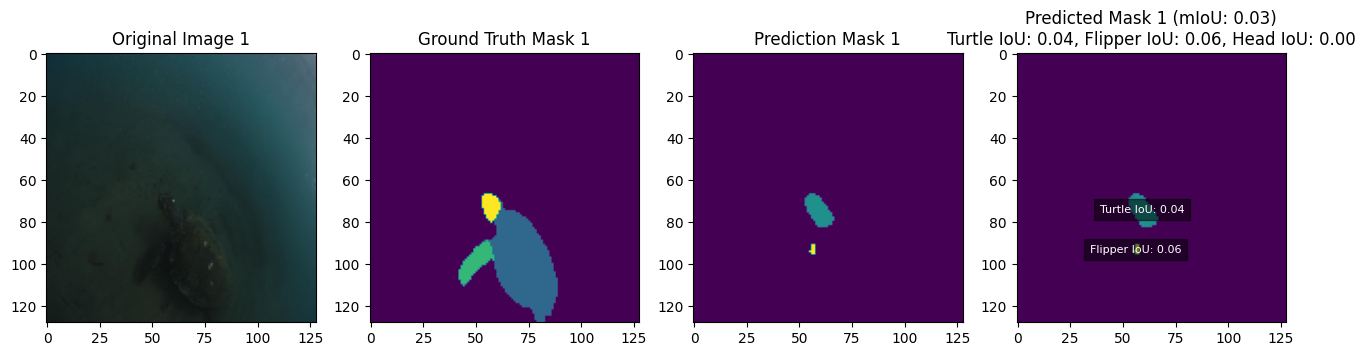

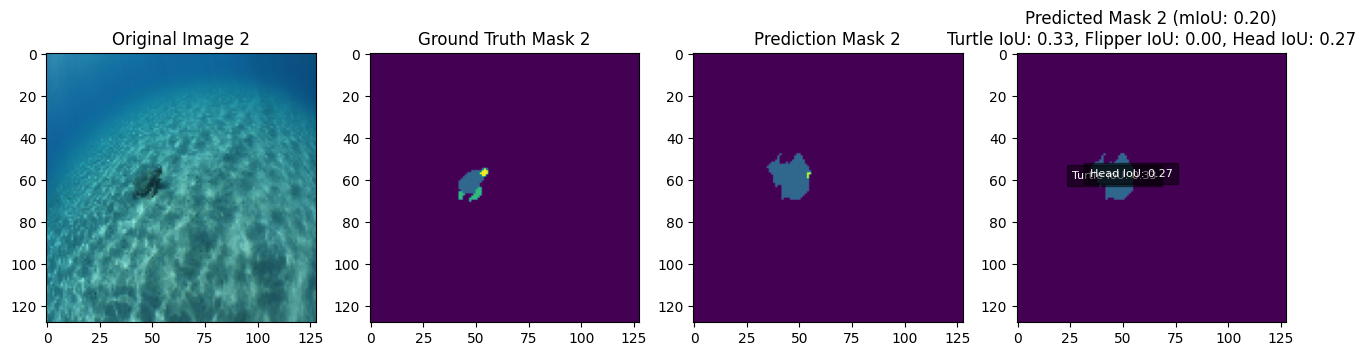

Images with good predictions:


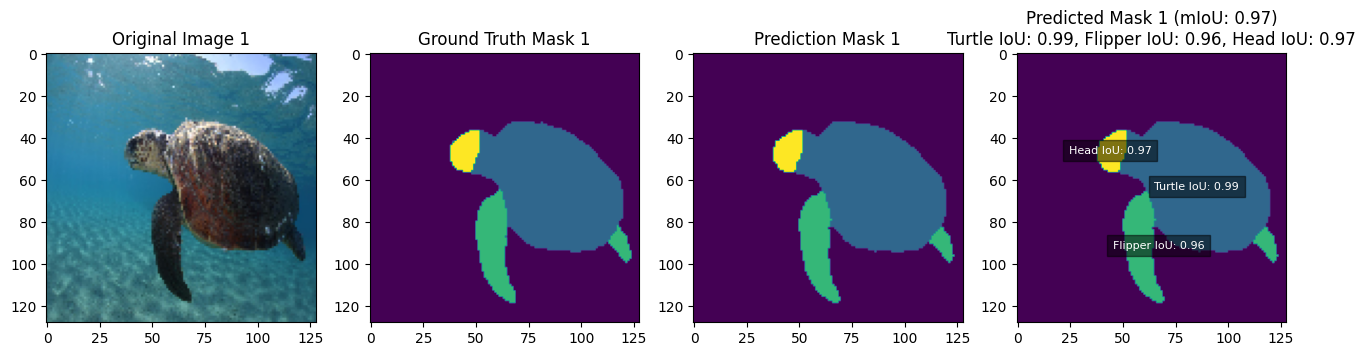

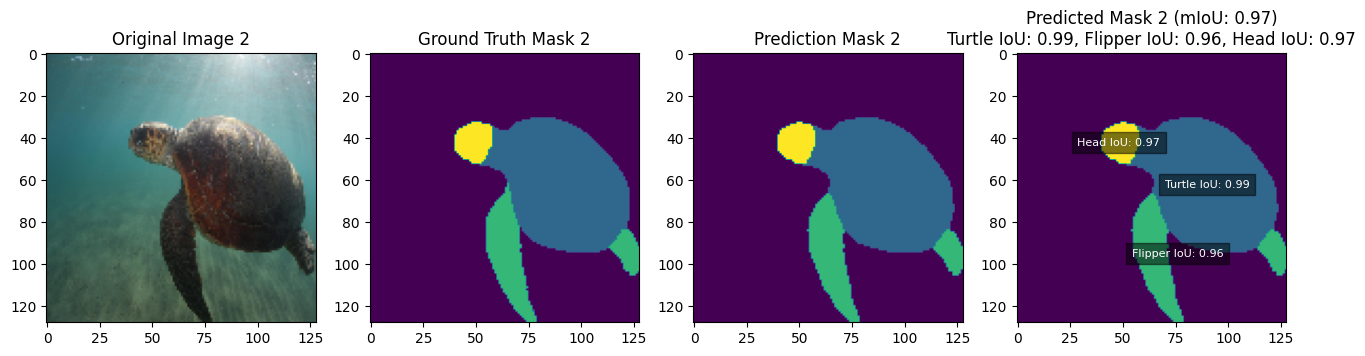

In [ ]:
def visualize_best_and_worst_predictions(model, dataloader, n_classes=4, good_num=2, bad_indices=[0, 3], show_iou=True):
    model.eval()
    image_results = []


    def compute_iou_per_class(pred, target, n_classes):

        iou_scores = []
        for cls in range(1, n_classes):
            pred_inds = (pred == cls)
            target_inds = (target == cls)


            intersection = (pred_inds & target_inds).sum().item()
            union = (pred_inds | target_inds).sum().item()


            if union == 0:
                iou_scores.append(float('nan'))
            else:
                iou_scores.append(intersection / union)

        return iou_scores

    def find_class_centroid(mask, class_id):

        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()


        class_pixels = np.argwhere(mask == class_id).astype(float)

        if len(class_pixels) == 0:
            return None


        centroid = class_pixels.mean(axis=0)
        y, x = int(centroid[0]), int(centroid[1])
        return (x, y)


    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)


            for j in range(len(images)):
                iou_scores = compute_iou_per_class(preds[j], masks[j], n_classes)
                mean_iou = np.nanmean(iou_scores)
                image_results.append((mean_iou, iou_scores, images[j].cpu(), masks[j].cpu(), preds[j].cpu()))


    image_results.sort(key=lambda x: x[0])


    bad_images = [image_results[i] for i in bad_indices]
    good_images = image_results[-good_num:]

    class_names = ['Turtle', 'Flipper', 'Head']


    print("Images with poor predictions:")
    for i, (mean_iou, iou_scores, image, mask, pred) in enumerate(bad_images):
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Original Image {i+1}")

        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap='viridis')
        plt.title(f"Ground Truth Mask {i+1}")

        plt.subplot(1, 4, 3)
        plt.imshow(pred, cmap='viridis')
        plt.title(f"Prediction Mask {i+1}")

        plt.subplot(1, 4, 4)
        iou_text = ", ".join([f"{class_names[idx]} IoU: {iou:.2f}" for idx, iou in enumerate(iou_scores)])
        plt.imshow(pred, cmap='viridis')

        # Display IoU scores at class locations on the predicted mask if show_iou is True
        if show_iou:
            for idx, iou in enumerate(iou_scores):
                class_id = idx + 1  # Classes start from 1
                centroid = find_class_centroid(pred, class_id)
                if centroid is not None:
                    plt.text(centroid[0], centroid[1], f"{class_names[idx]} IoU: {iou:.2f}",
                             color='white', fontsize=8, ha='center', va='center',
                             bbox=dict(facecolor='black', alpha=0.5))

        plt.title(f"Predicted Mask {i+1} (mIoU: {mean_iou:.2f})\n{iou_text}")
        plt.show()

    print("Images with good predictions:")
    for i, (mean_iou, iou_scores, image, mask, pred) in enumerate(good_images):
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Original Image {i+1}")

        plt.subplot(1, 4, 2)
        plt.imshow(mask, cmap='viridis')
        plt.title(f"Ground Truth Mask {i+1}")

        plt.subplot(1, 4, 3)
        plt.imshow(pred, cmap='viridis')
        plt.title(f"Prediction Mask {i+1}")

        plt.subplot(1, 4, 4)
        iou_text = ", ".join([f"{class_names[idx]} IoU: {iou:.2f}" for idx, iou in enumerate(iou_scores)])
        plt.imshow(pred, cmap='viridis')

        # Display IoU scores at class locations on the predicted mask if show_iou is True
        if show_iou:
            for idx, iou in enumerate(iou_scores):
                class_id = idx + 1  # Classes start from 1
                centroid = find_class_centroid(pred, class_id)
                if centroid is not None:
                    plt.text(centroid[0], centroid[1], f"{class_names[idx]} IoU: {iou:.2f}",
                             color='white', fontsize=8, ha='center', va='center',
                             bbox=dict(facecolor='black', alpha=0.5))

        plt.title(f"Predicted Mask {i+1} (mIoU: {mean_iou:.2f})\n{iou_text}")
        plt.show()


visualize_best_and_worst_predictions(base_model, test_dataloader, n_classes=4, good_num=2, bad_indices=[1, 3])


### Optimization 1


#### Cross-Entropy + Focal Tversky Loss
Focal Tversky Loss:

- This can be helpful in handling class imbalance by prioritizing certain types of errors.
- The Tversky Loss is calculated as  1 - Tversky Index, where the index is formulated to give a score based on true positives (TP), false positives (FP), and false negatives (FN).
- By introducing a gamma parameter, which reduces the loss contribution from well-classified areas and focuses more on hard-to-classify regions.

#### Adam with weight decay + Learning Rate Scheduler
Combined Loss Function:
- The combined_loss function calculates both the cross-entropy loss and the focal Tversky loss and returns their sum.
- *This* combined approach leverages both pixel-level classification accuracy and the Focal Tversky’s ability to handle imbalanced class distributions, improving segmentation performance, especially for complex or imbalanced datasets.

- The optimizer used is AdamW, which combines Adam with weight decay (regularization) to help prevent overfitting.

- Scheduler monitors the validation loss and adjusts the learning rate based on its trends.

    - The configuration parameters:
	- mode=‘min’: The scheduler reduces the learning rate when the monitored validation loss does not decrease (since a lower validation loss is better).
	- factor=0.5: Each time the condition is met, the learning rate is reduced by a factor of 50%.
	- patience=3: If the validation loss does not improve for 3 consecutive epochs, the scheduler triggers a reduction in the learning rate.
	- min_lr=1e-6: The learning rate has a lower limit of 1e-6, ensuring it does not decrease indefinitely.
	- verbose=True: Enables output messages, so you’ll see notifications each time the learning rate is adjusted.

This setup helps adaptively reduce the learning rate when progress stalls, allowing the model to continue fine-tuning without manually adjusting the learning rate.

In [ ]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = torch.softmax(outputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=outputs.size(1)).permute(0, 3, 1, 2).float()

        tp = (outputs * targets_one_hot).sum(dim=(2, 3))
        fp = ((1 - targets_one_hot) * outputs).sum(dim=(2, 3))
        fn = (targets_one_hot * (1 - outputs)).sum(dim=(2, 3))

        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky_index.mean()

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=0.75, smooth=1):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, outputs, targets):
        tversky_loss = TverskyLoss(self.alpha, self.beta, self.smooth)(outputs, targets)
        return torch.pow(tversky_loss, self.gamma)
criterion_ce = nn.CrossEntropyLoss()
criterion_tversky = FocalTverskyLoss(alpha=0.5, beta=0.5, smooth=1)

def combined_loss(outputs, targets):
    ce_loss = criterion_ce(outputs, targets)
    tversky_loss = criterion_tversky(outputs, targets)
    return ce_loss + tversky_loss


In [ ]:
# Using the ReduceLROnPlateau scheduler
optimizer = optim.AdamW(base_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Choose minimization mode because we want the validation loss to be as low as possible
    factor=0.5,         # When the conditions are met, reduce the learning rate to 50% of the original
    patience=3,         # when validation loss does not decrease within 3 epochs, reduce learning rate
    min_lr=1e-6,        # Set the lower limit of learning rate
    verbose=True        # Output learning rate adjustment information
)

In [ ]:
# Train the model
optimized_model_1 = UNet().to(device)
optimizer = optim.AdamW(optimized_model_1.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Choose minimization mode because we want the validation loss to be as low as possible
    factor=0.5,         # When the conditions are met, reduce the learning rate to 50% of the original
    patience=3,         # when validation loss does not decrease within 3 epochs, reduce learning rate
    min_lr=1e-6,        # Set the lower limit of learning rate
    verbose=True        # Output learning rate adjustment information
)
train_losses, val_losses = [], []
train_model(optimized_model_1, train_dataloader, valid_dataloader, combined_loss, optimizer, scheduler=scheduler,train_losses = train_losses,val_losses= val_losses, num_epochs=40,patience=5)

Epoch 1/40, Training Loss: 0.9135
Epoch 1/40, Validation Loss: 0.7123
Validation loss improved. Model saved at Epoch 1.
Epoch 2/40, Training Loss: 0.6055
Epoch 2/40, Validation Loss: 0.5632
Validation loss improved. Model saved at Epoch 2.
Epoch 3/40, Training Loss: 0.4875
Epoch 3/40, Validation Loss: 0.5015
Validation loss improved. Model saved at Epoch 3.
Epoch 4/40, Training Loss: 0.4149
Epoch 4/40, Validation Loss: 0.4785
Validation loss improved. Model saved at Epoch 4.
Epoch 5/40, Training Loss: 0.3595
Epoch 5/40, Validation Loss: 0.4234
Validation loss improved. Model saved at Epoch 5.
Epoch 6/40, Training Loss: 0.3255
Epoch 6/40, Validation Loss: 0.3396
Validation loss improved. Model saved at Epoch 6.
Epoch 7/40, Training Loss: 0.2901
Epoch 7/40, Validation Loss: 0.3332
Validation loss improved. Model saved at Epoch 7.
Epoch 8/40, Training Loss: 0.2647
Epoch 8/40, Validation Loss: 0.3527
No improvement in validation loss for 1 epoch(s).
Epoch 9/40, Training Loss: 0.2544
Epoch 

In [ ]:
# Save the model
torch.save(optimized_model_1.state_dict(), 'U-Net_optimized_1.pth')

In [ ]:
# Evaluate the model on the test set
print("Evaluating the optimized model of U-Net on the test set...")
evaluate_model(optimized_model_1, test_dataloader, 4)

Evaluating the optimized model of U-Net on the test set...
Turtle mIoU: 0.8908
Flipper mIoU: 0.7768
Head mIoU: 0.8168
Mean IoU across all classes: 0.8281312506125458


C:\Users\75152\AppData\Local\Temp\ipykernel_31584\929993741.py:13: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(iou_scores)  # 计算所有类别的平均 IoU


Images with poor predictions:


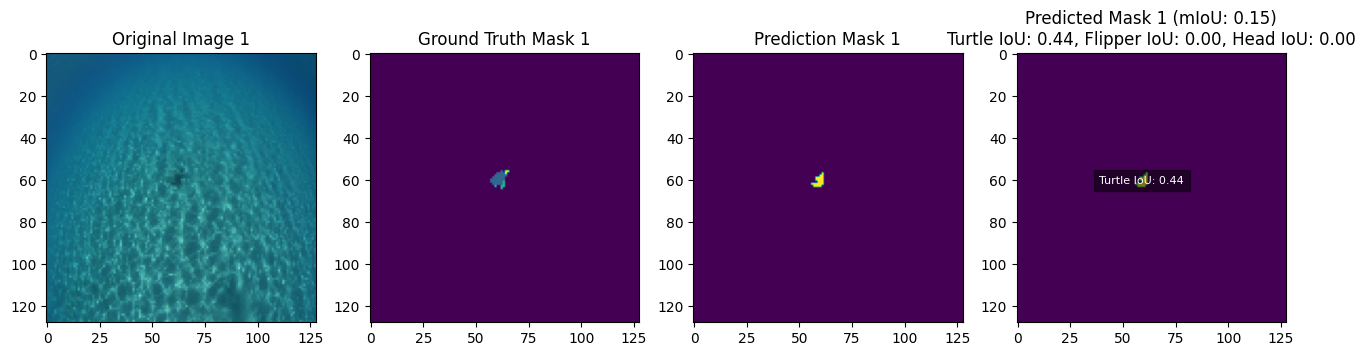

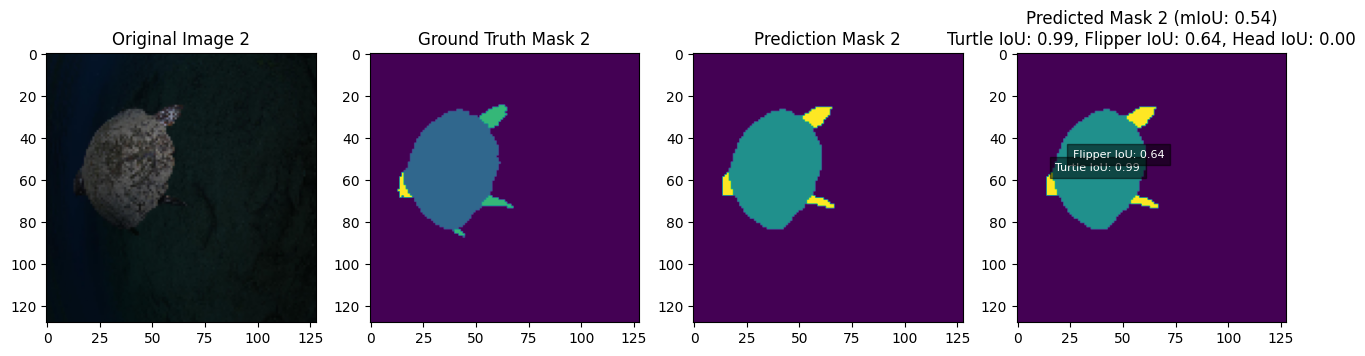

Images with good predictions:


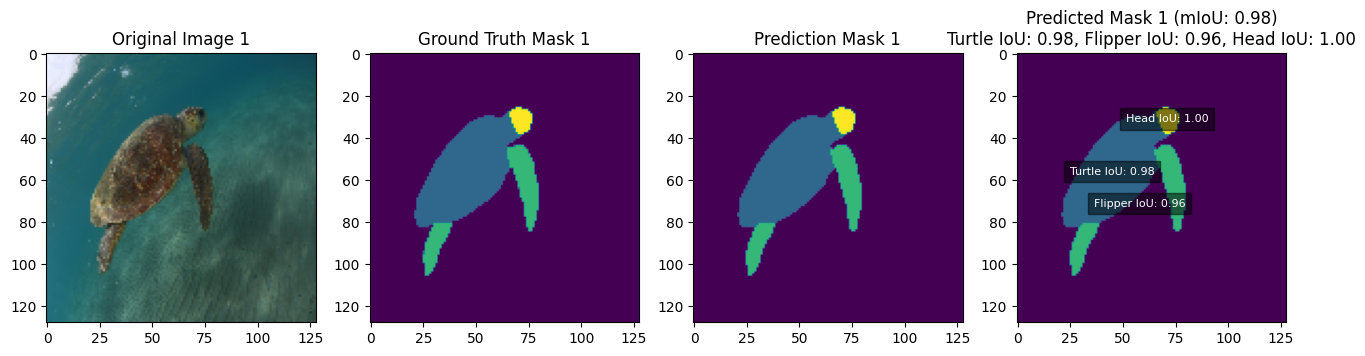

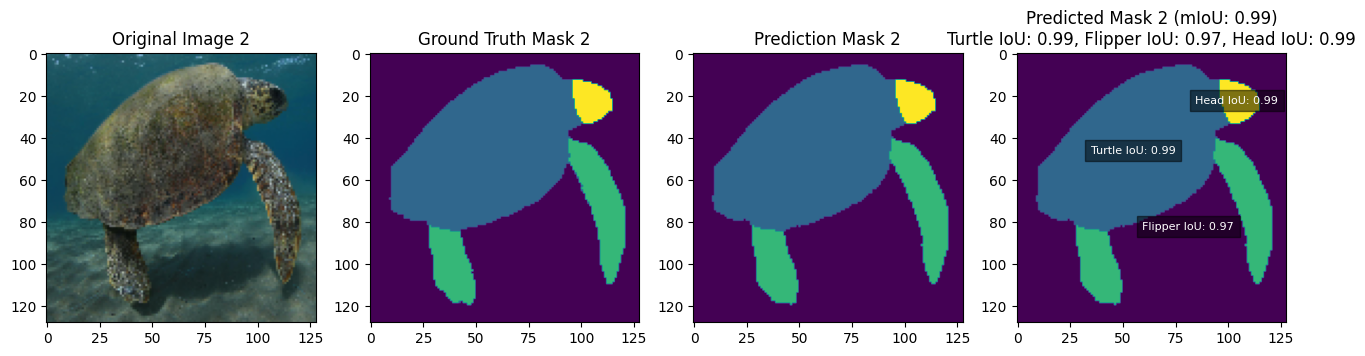

In [ ]:

visualize_best_and_worst_predictions(optimized_model_1, test_dataloader, n_classes=4, good_num=2, bad_indices=[2, 5])

### Optimization 2: Replacing backbone

To further optimize the UNet model, we replace its backbone with re-trained ResNet-34 for improved feature extraction.

In [ ]:
class ResNetUNet(nn.Module):
    def __init__(self, n_classes):
        super(ResNetUNet, self).__init__()

        # Load a pretrained ResNet model
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        # Use the ResNet layers as encoder
        self.enc1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu
        )  # Output: [batch_size, 64, H/2, W/2]
        self.enc2 = nn.Sequential(
            resnet.maxpool,
            resnet.layer1
        )  # Output: [batch_size, 64, H/4, W/4]
        self.enc3 = resnet.layer2  # Output: [batch_size, 128, H/8, W/8]
        self.enc4 = resnet.layer3  # Output: [batch_size, 256, H/16, W/16]
        self.enc5 = resnet.layer4  # Output: [batch_size, 512, H/32, W/32]

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # Decoder layers with upsampling
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(512 + 256, 512)  # Match channels for concatenation

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(256 + 128, 256)  # Match channels for concatenation

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(128 + 64, 128)  # Match channels for concatenation

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(64 + 64, 64)  # Match channels for concatenation

        # Output layer
        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Double convolutional layers with batch normalization."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.enc1(x)    # [batch_size, 64, H/2, W/2]
        e2 = self.enc2(e1)   # [batch_size, 64, H/4, W/4]
        e3 = self.enc3(e2)   # [batch_size, 128, H/8, W/8]
        e4 = self.enc4(e3)   # [batch_size, 256, H/16, W/16]
        e5 = self.enc5(e4)   # [batch_size, 512, H/32, W/32]

        # Bottleneck
        b = self.bottleneck(e5)  # [batch_size, 1024, H/32, W/32]

        # Decoding path
        d4 = self.upconv4(b)     # [batch_size, 512, H/16, W/16]
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)       # [batch_size, 512, H/16, W/16]

        d3 = self.upconv3(d4)    # [batch_size, 256, H/8, W/8]
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)       # [batch_size, 256, H/8, W/8]

        d2 = self.upconv2(d3)    # [batch_size, 128, H/4, W/4]
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)       # [batch_size, 128, H/4, W/4]

        d1 = self.upconv1(d2)    # [batch_size, 64, H/2, W/2]
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)       # [batch_size, 64, H/2, W/2]

        # Final output
        out = self.conv_last(d1)  # [batch_size, n_classes, H/2, W/2]
        out = F.interpolate(out, size=x.size()[2:], mode='bilinear', align_corners=False)

        return out

optimized_model_2 = ResNetUNet(4).to(device)

# Using the ReduceLROnPlateau scheduler
optimizer = optim.AdamW(optimized_model_2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Choose minimization mode because we want the validation loss to be as low as possible
    factor=0.5,         # When the conditions are met, reduce the learning rate to 50% of the original
    patience=3,         # when validation loss does not decrease within 3 epochs, reduce learning rate
    min_lr=1e-6,        # Set the lower limit of learning rate
    verbose=True        # Output learning rate adjustment information
)

In [ ]:
# Train the model
train_losses, val_losses = [], []
train_model(optimized_model_2, train_dataloader, valid_dataloader, combined_loss, optimizer, scheduler=scheduler,train_losses = train_losses,val_losses= val_losses, num_epochs=40,patience=5)


Epoch 1/40, Training Loss: 0.6655
Epoch 1/40, Validation Loss: 0.4999
Validation loss improved. Model saved at Epoch 1.
Epoch 2/40, Training Loss: 0.3871
Epoch 2/40, Validation Loss: 0.3819
Validation loss improved. Model saved at Epoch 2.
Epoch 3/40, Training Loss: 0.3274
Epoch 3/40, Validation Loss: 0.3686
Validation loss improved. Model saved at Epoch 3.
Epoch 4/40, Training Loss: 0.2971
Epoch 4/40, Validation Loss: 0.3163
Validation loss improved. Model saved at Epoch 4.
Epoch 5/40, Training Loss: 0.2612
Epoch 5/40, Validation Loss: 0.3306
No improvement in validation loss for 1 epoch(s).
Epoch 6/40, Training Loss: 0.2657
Epoch 6/40, Validation Loss: 0.3471
No improvement in validation loss for 2 epoch(s).
Epoch 7/40, Training Loss: 0.2394
Epoch 7/40, Validation Loss: 0.3525
No improvement in validation loss for 3 epoch(s).
Epoch 8/40, Training Loss: 0.2271
Epoch 8/40, Validation Loss: 0.4866
No improvement in validation loss for 4 epoch(s).
Epoch 00008: reducing learning rate of g

In [ ]:
# Save the model
torch.save(optimized_model_2.state_dict(), 'U-net_ResNet.pth')

In [ ]:
# Evaluate the model on the test set
print("Evaluating the U-Net model on the test set...")
evaluate_model(optimized_model_2, test_dataloader, 4)

Evaluating the U-Net model on the test set...
Turtle mIoU: 0.8699
Flipper mIoU: 0.7214
Head mIoU: 0.7708
Mean IoU across all classes: 0.7873507085931643


Images with poor predictions:


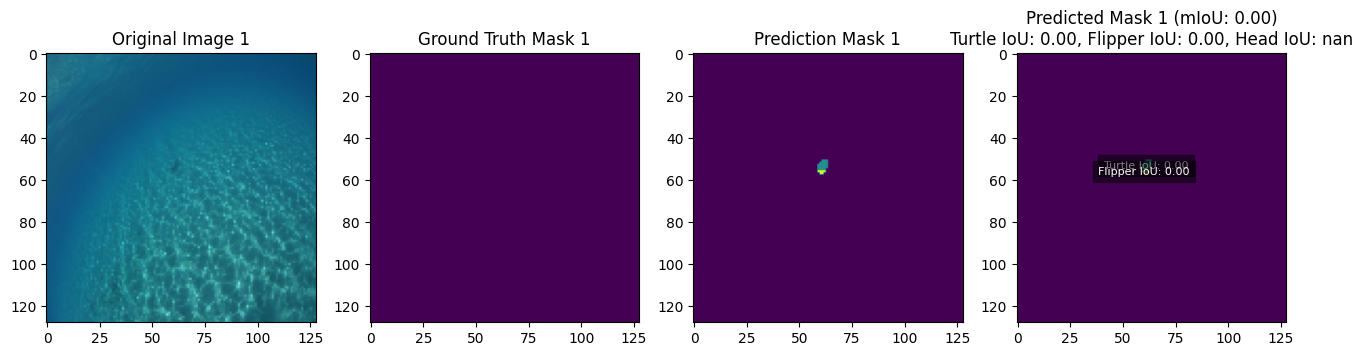

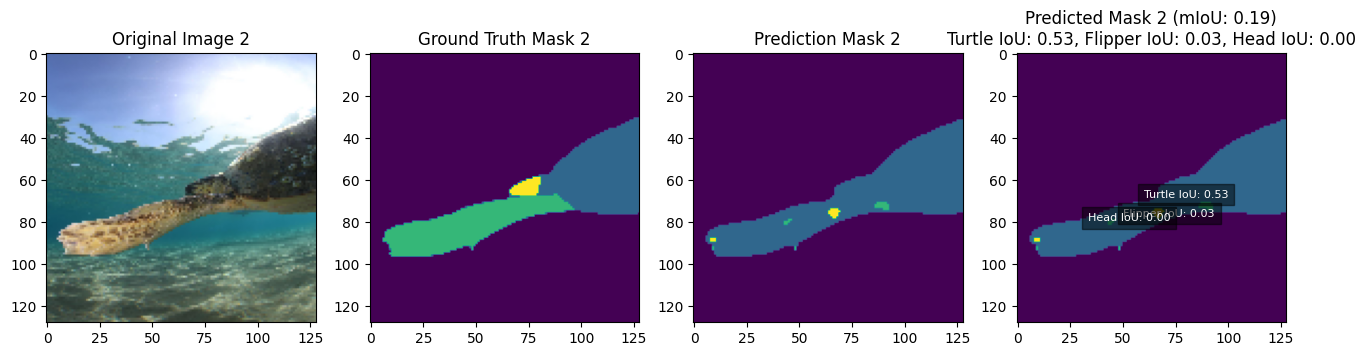

Images with good predictions:


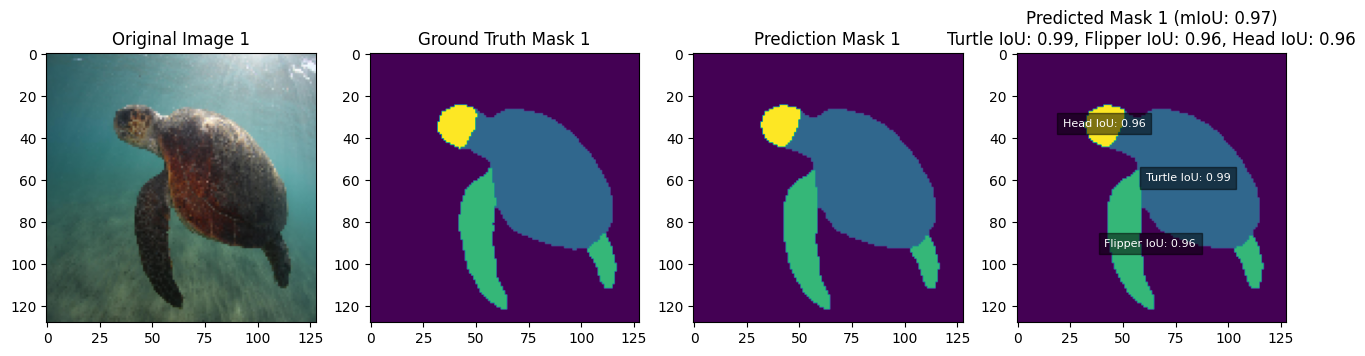

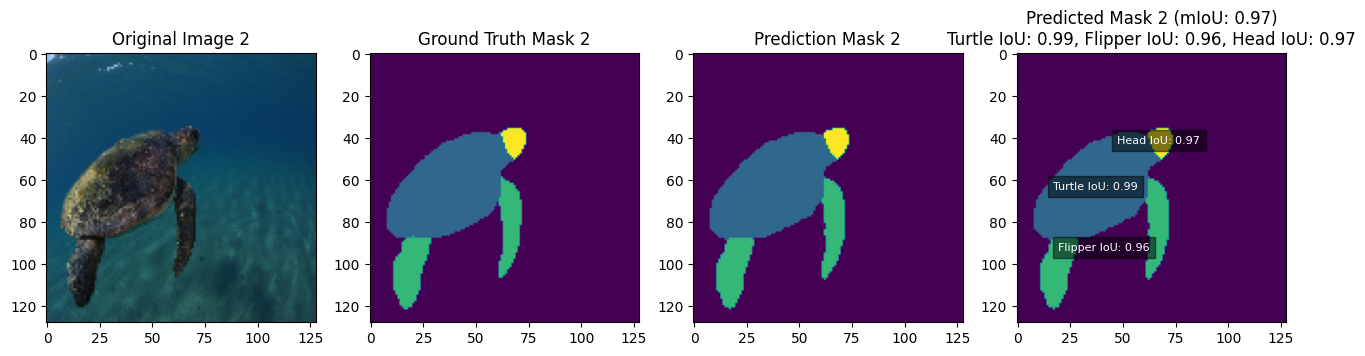

In [ ]:

visualize_best_and_worst_predictions(optimized_model_2, test_dataloader, n_classes=4, good_num=2, bad_indices=[0, 7])

### Optimization 3: Integrate an attention mechanism

An attention module (CBAM) can enhance segmentation accuracy by focusing on critical areas in the images.

- CBAM adds both channel and spatial attention modules to emphasize the most important regions in each decoder stage.
- This allows the model to focus more on relevant parts of each feature map, improving segmentation quality.

In [ ]:
# Define Channel and Spatial Attention
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        avg_pool = x.mean(dim=(2, 3), keepdim=True).view(batch_size, channels)
        max_pool = x.amax(dim=(2, 3), keepdim=True).view(batch_size, channels)
        avg_out = self.fc2(self.relu(self.fc1(avg_pool)))
        max_out = self.fc2(self.relu(self.fc1(max_pool)))
        out = avg_out + max_out
        return self.sigmoid(out).view(batch_size, channels, 1, 1) * x

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = x.mean(dim=1, keepdim=True)
        max_pool = x.max(dim=1, keepdim=True)[0]
        out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.sigmoid(self.conv(out))
        return out * x

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

# Define the U-Net model with CBAM
class UNet_Attention(nn.Module):
    def __init__(self, n_classes):
        super(UNet_Attention, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),
                CBAM(out_ch)  # Add CBAM after each CBR module
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = CBR(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = CBR(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = CBR(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = CBR(128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.conv_last(d1)  # Outputs raw logits

# Instantiate the model
n_classes = 4  # Including background
optimized_model_3 = UNet_Attention(n_classes).cuda()

optimizer = optim.AdamW(optimized_model_3.parameters(), lr=0.001, weight_decay=1e-4)
# Using the ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Choose minimization mode because we want the validation loss to be as low as possible
    factor=0.5,         # When the conditions are met, reduce the learning rate to 50% of the original
    patience=3,         # when validation loss does not decrease within 3 epochs, reduce learning rate
    min_lr=1e-6,        # Set the lower limit of learning rate
    verbose=True        # Output learning rate adjustment information
)

In [ ]:
# Train the model
train_losses, val_losses = [], []
train_model(optimized_model_3, train_dataloader, valid_dataloader, combined_loss, optimizer, scheduler=scheduler,train_losses = train_losses,val_losses= val_losses, num_epochs=40,patience=5)


Epoch 1/40, Training Loss: 0.9264
Epoch 1/40, Validation Loss: 0.6381
Validation loss improved. Model saved at Epoch 1.
Epoch 2/40, Training Loss: 0.5406
Epoch 2/40, Validation Loss: 0.4484
Validation loss improved. Model saved at Epoch 2.
Epoch 3/40, Training Loss: 0.4360
Epoch 3/40, Validation Loss: 0.4220
Validation loss improved. Model saved at Epoch 3.
Epoch 4/40, Training Loss: 0.3739
Epoch 4/40, Validation Loss: 0.4091
Validation loss improved. Model saved at Epoch 4.
Epoch 5/40, Training Loss: 0.3315
Epoch 5/40, Validation Loss: 0.3223
Validation loss improved. Model saved at Epoch 5.
Epoch 6/40, Training Loss: 0.3020
Epoch 6/40, Validation Loss: 0.3320
No improvement in validation loss for 1 epoch(s).
Epoch 7/40, Training Loss: 0.2798
Epoch 7/40, Validation Loss: 0.3274
No improvement in validation loss for 2 epoch(s).
Epoch 8/40, Training Loss: 0.2732
Epoch 8/40, Validation Loss: 0.2911
Validation loss improved. Model saved at Epoch 8.
Epoch 9/40, Training Loss: 0.2444
Epoch 

In [ ]:
# Save the model
torch.save(optimized_model_3.state_dict(), 'U-net_Attention.pth')

In [ ]:
# Evaluate the model on the test set
print("Evaluating the U-Net model on the test set...")
evaluate_model(optimized_model_3, test_dataloader, 4)

Evaluating the U-Net model on the test set...
Turtle mIoU: 0.8969
Flipper mIoU: 0.7814
Head mIoU: 0.8202
Mean IoU across all classes: 0.8328498514334415


Images with poor predictions:


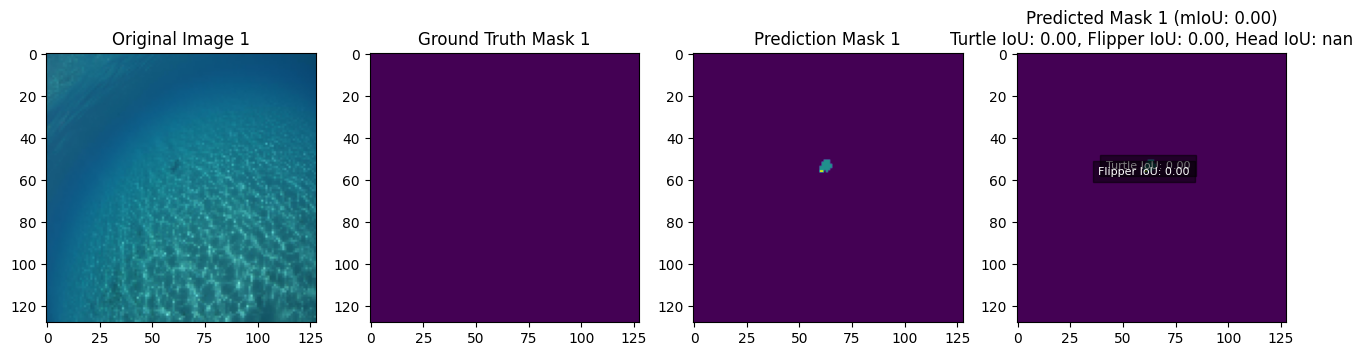

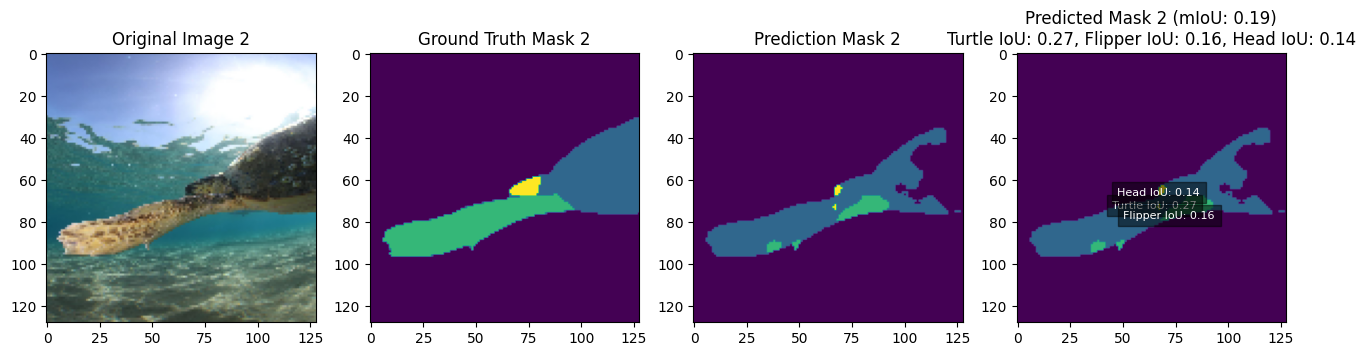

Images with good predictions:


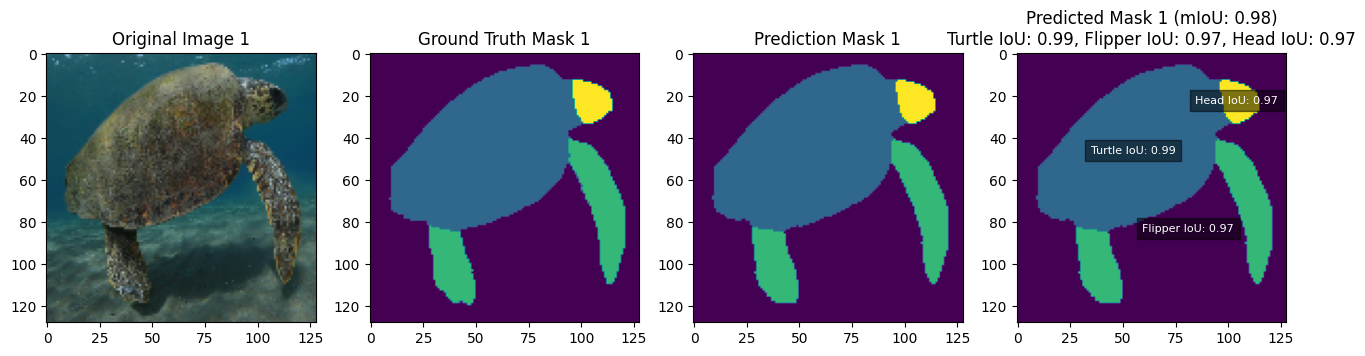

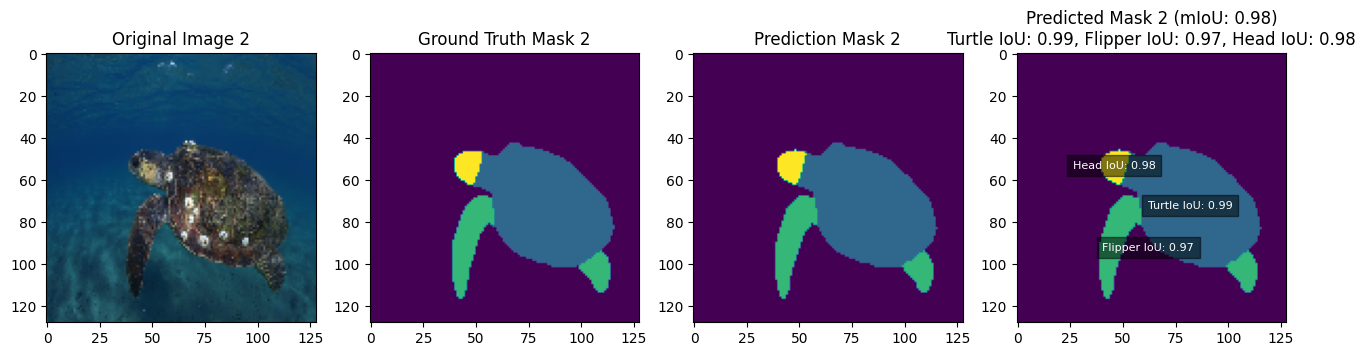

In [ ]:

visualize_best_and_worst_predictions(optimized_model_3, test_dataloader, n_classes=4, good_num=2, bad_indices=[0, 4])